In [0]:
# import useful packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import LSTM,Input,Dense,SpatialDropout1D,Dropout,CuDNNLSTM
from keras.layers import BatchNormalization, Activation, Bidirectional, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K 
from sklearn.preprocessing import LabelEncoder



In [2]:
# Mount google drive for easy access of dataset
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Converting file from CSV to Pandas

X_train = pd.read_csv('gdrive/My Drive/career-con-2019/X_train.csv')
X_test = pd.read_csv('gdrive/My Drive/career-con-2019/X_test.csv')
y_train = pd.read_csv('gdrive/My Drive/career-con-2019/y_train.csv')

# Display the first five rows
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
# basic information about types of dataset within each column
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [5]:
# Display mean, median, SD, max and min in each column
X_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


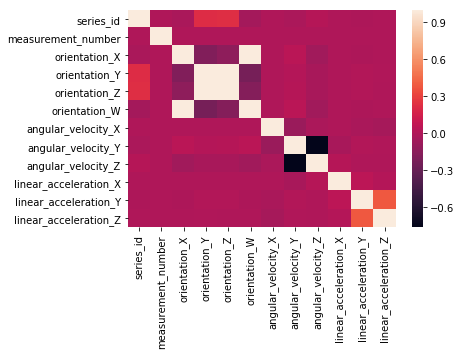

In [6]:
# plot the correlation graph
corr = X_train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [7]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 3 columns):
series_id    3810 non-null int64
group_id     3810 non-null int64
surface      3810 non-null object
dtypes: int64(2), object(1)
memory usage: 89.4+ KB


In [8]:
# Display first 10 rows in y_train
y_train.head(10)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
5,5,1,tiled
6,6,34,soft_pvc
7,7,31,concrete
8,8,33,hard_tiles_large_space
9,9,11,tiled


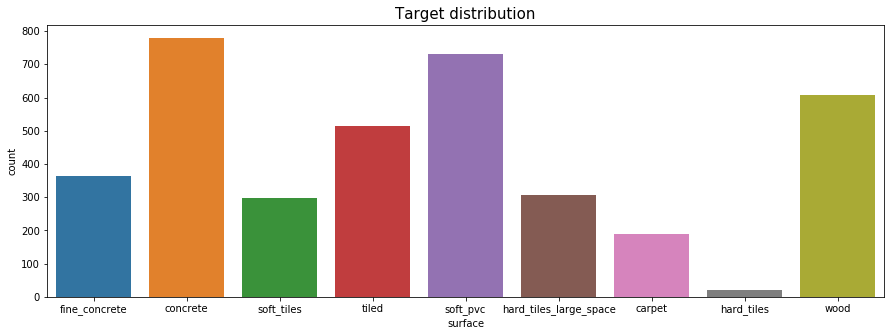

In [9]:
# Plot the target distribution
plt.figure(figsize=(15, 5))
sns.countplot(y_train['surface'])
plt.title('Target distribution', size=15)
plt.show()

In [0]:

# Convert fron quat to eular
def  quat_to_euler(X):
  #roll
  sinr_cosp = 2.0 * (X['orientation_W'] * X['orientation_X'] +
                      X['orientation_Y'] * X['orientation_Z'])
  cosr_cosp = 1.0 - 2.0 * (X['orientation_Y'] * X['orientation_Y'] +
                      X['orientation_Z'] * X['orientation_Z'])
  roll = np.arctan(np.array(sinr_cosp), np.array(cosr_cosp))


  #Pitch
  pitch = np.arcsin(np.array(2*(X['orientation_W']*X['orientation_Y'] -
                                X['orientation_Z']*X['orientation_X'])))


  #Yaw
  siny_cosp = 2.0 * (X['orientation_W'] * X['orientation_Z'] +
                      X['orientation_X'] * X['orientation_Y'])
  cosy_cosp = 1.0 - 2.0 * (X['orientation_Y'] * X['orientation_Y'] +
                      X['orientation_Z'] * X['orientation_Z'])
  yaw = np.arctan(np.array(siny_cosp), np.array(cosy_cosp))

  return np.array([roll, pitch, yaw])


In [0]:
euler_angle_train = quat_to_euler(X_train)
euler_angle_test = quat_to_euler(X_test)

In [12]:
X_train['roll'] = euler_angle_train[0]
X_train['pitch'] = euler_angle_train[1]
X_train['yaw'] = euler_angle_train[2]

X_test['roll'] = euler_angle_test[0]
X_test['pitch'] = euler_angle_test[1]
X_test['yaw'] = euler_angle_test[2]

X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,roll,pitch,yaw
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.285781,-0.024668,0.777626
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.285845,-0.024662,0.777624
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.285828,-0.024728,0.777630
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.285863,-0.024770,0.777635
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.285847,-0.024784,0.777626


In [13]:
# Droping the following columns: ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W'] in both testing and training dataset

X_train.drop(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W'], axis=1, inplace=True)
X_test.drop(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W'], axis=1, inplace=True)
X_train.head()

,row_id,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,roll,pitch,yaw
0,0_0,0,0,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.285781,-0.024668,0.777626
1,0_1,0,1,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.285845,-0.024662,0.777624
2,0_2,0,2,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.285828,-0.024728,0.777630
3,0_3,0,3,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.285863,-0.024770,0.777635
4,0_4,0,4,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.285847,-0.024784,0.777626


In [0]:
num_measurement = 128
num_series = X_train['series_id'].nunique()

In [0]:
# selecting feature column

feature_cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 
               'linear_acceleration_Y', 'linear_acceleration_Z', 'roll', 'pitch', 'yaw']
feature_arr = np.array(X_train[feature_cols])

# Reshaping the data from 2D to 3D
feature_arr = np.reshape(feature_arr, [num_series, num_measurement, len(feature_cols)])

In [0]:
# calculate the first order differential of the folowing columns: ['roll','pitch','yaw'] 
euler_cols = ['roll','pitch','yaw']
for ec in euler_cols:
    iia = feature_cols.index(ec)
    np_arr = feature_arr[:,:,iia]
    roll_arr = np.copy(np_arr)
    roll_arr[:,1:] = roll_arr[:,:-1]
    np_arr = np_arr - roll_arr
    feature_arr[:,:,iia] = np_arr

In [18]:
# Apply Fourier Transformation to feat_fft_array
def absfft(x):
    return np.abs(np.fft.rfft(x))

feat_fft_array = np.copy(feature_arr[:,:,:6])
feat_fft_array = np.apply_along_axis(absfft,1,feat_fft_array)
feat_fft_array.shape

(3810, 65, 6)

In [0]:
# Normilise both data set

feature_cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 
               'linear_acceleration_Y', 'linear_acceleration_Z', 'roll','pitch','yaw']
for col in feature_cols:
    idx = feature_cols.index(col)
    np_arr = feature_arr[:,:,idx]
    mean_arr = np.mean(np_arr,1)
    mean_arr = np.expand_dims(mean_arr,1)
    mean_arr = np.repeat(mean_arr,num_measurement,1)
    np_arr = np_arr - mean_arr
    feature_arr[:,:,idx] = np_arr
    
sub_feature_cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 
               'linear_acceleration_Y', 'linear_acceleration_Z']
for col in sub_feature_cols:
    idx = sub_feature_cols.index(col)
    np_arr_f = feat_fft_array[:,:,idx]
    mean_arr_f = np.mean(np_arr_f,1)
    mean_arr_f = np.expand_dims(mean_arr_f,1)
    mean_arr_f = np.repeat(mean_arr_f,65,1)
    np_arr_f = np_arr_f - mean_arr_f
    feat_fft_array[:,:,idx] = np_arr_f

<Figure size 432x288 with 0 Axes>

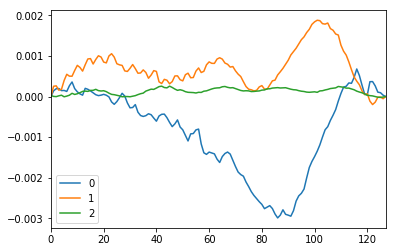

In [20]:
% matplotlib inline
df = pd.DataFrame(feature_arr[10,:,6:])

df = df.cumsum()

plt.figure();

df.plot();

In [0]:
le = LabelEncoder()
le.fit(list(y_train["surface"]))
y = to_categorical(le.transform(list(y_train["surface"])))

In [0]:
def LSTM(drop):
    input_data = Input(shape=(128,9))
    input_data_fft = Input(shape=(65,6))
  
    # First Architecture
    
    x = CuDNNLSTM(units=200, return_sequences=True, return_state=False)(input_data)
    x = Dropout(drop)(x)
    
    x = CuDNNLSTM(units=100, return_sequences=True, return_state=False)(x)
    x = Dropout(drop)(x)
    
    x = CuDNNLSTM(units=50, return_sequences=True, return_state=False)(x)
    x = Dropout(drop)(x)
    x = CuDNNLSTM(units=50, return_sequences=False, return_state=False)(x)
    x = Dropout(drop)(x)
    
    
    x = Dense(80)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop)(x)
         
    x = Dense(40)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop)(x)
    
    x = Dense(20)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop)(x)
    
    # Second Architecture
    
    x1 = CuDNNLSTM(units=200, return_sequences=True, return_state=False)(input_data_fft)
    x1 = Dropout(drop)(x1)
    x1 = CuDNNLSTM(units=200, return_sequences=True, return_state=False)(x1)
    x1 = Dropout(drop)(x1)
    
    
    x1 = CuDNNLSTM(units=60, return_sequences=True, return_state=False)(input_data_fft)
    x1 = Dropout(drop)(x1)
    x1 = CuDNNLSTM(units=60, return_sequences=False, return_state=False)(x1)
    x1 = Dropout(drop)(x1)
    
    
    x1 = Dense(70)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Dropout(drop)(x1)
    
    x1 = Dense(50)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Dropout(drop)(x1)
    
    x1 = Dense(20)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Dropout(drop)(x1)
    
    x = concatenate([x,x1])
    
    x = Dense(50)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop)(x)
    
    output = Dense(9, activation="softmax")(x)
    
    model = Model(inputs= [input_data, input_data_fft], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [36]:
from sklearn.metrics import *
from sklearn.model_selection import *

X =  np.copy(feature_arr)
X1 = np.copy(feat_fft_array)
Y = np.array(list(y_train["surface"]))
folds = list(StratifiedKFold(n_splits= 3).split(X, Y))


for i, (train_idx, val_idx) in  enumerate(folds):
    print(f"Fold {i+1}")
    model = LSTM(0.5)
    model.fit([X[train_idx], X1[train_idx]], y[train_idx], batch_size=65, epochs=200, 
              validation_data=[[X[val_idx], X1[val_idx]], y[val_idx]], verbose=0)

    pred_val = np.argmax(model.predict([X[val_idx], X1[val_idx]]), axis=1)
    pred_train = np.argmax(model.predict([X[train_idx], X1[train_idx]]), axis=1)
    
    score_val = accuracy_score(pred_val, np.argmax(y[val_idx], axis=1))
    score_train = accuracy_score(pred_train, np.argmax(y[train_idx], axis=1))
    

    print(f'Scored {score_train:.3f} on training data, Scored {score_val:.3f} on validation data')




Fold 1
Scored 0.579 on training data, Scored 0.284 on validation data
Fold 2
Scored 0.519 on training data, Scored 0.425 on validation data
Fold 3
Scored 0.504 on training data, Scored 0.390 on validation data
